In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


CondenseNet Goes Wrong
===

This notebook looks at from when CondenseNet pruning goes wrong and whether there is any chance we can recover from them.

In [108]:
import os
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr   

## Plot the GOpt procedure.

In order to identify the position that CondenseNet pruning goes wrong, here we load all the training logs and plot the change in training and validation accuracy to see how it actually happens.

In [70]:
def load_gopt_logs(out_dir):
    """ Load log files from all gopt steps. """
    n_step = len(os.listdir(out_dir)) - 1 # exclude the log.txt

    df = None
    for i in range(n_step):
        step_dir = os.path.join(out_dir, 'step_{}'.format(i + 1))
        log_file = os.path.join(step_dir, 'log.txt')
        df_ = pd.read_csv(log_file, sep='\t')
        df_ = df_.loc[:, ~df_.columns.str.contains('^Unnamed')]
        df_ = df_.loc[[df_['Valid Acc.'].idxmax()]]

        if df is None:
            df = df_
        else:
            df = pd.concat([df, df_])
    
    return df

In [71]:
base_dir = '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/final/condensenet86/cifar100/prune/G_4/gopt_v2/'
out_dirs = {
    'lr_1e-3_epochs_30': 'P0.52_MIN8_dyn_LR_1e-3_cosine_max_30',
    'epochs_1': 'P0.52_MIN4_wd_5e-3_LR_1e-4_epoch_1',
    'epochs_10': 'P0.52_MIN4_wd_5e-4_LR_1e-4_epoch_10',
    'epochs_100_MAX16_0.05': 'P0.52_MIN4_MAX16_wd_1e-4_LR_1e-4_epoch_100_acc_5e-2'
}
dfs = [load_gopt_logs(os.path.join(base_dir, d)) for d in out_dirs.values()]

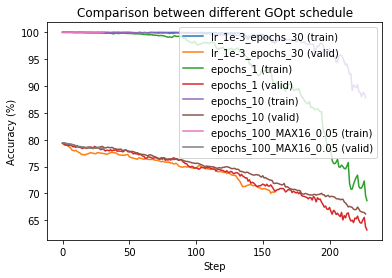

In [72]:
labels = list(out_dirs.keys())
for i, df in enumerate(dfs):
    plt.plot(np.arange(len(df)), df['Train Acc.'], label='{} (train)'.format(labels[i]))
    plt.plot(np.arange(len(df)), df['Valid Acc.'], label='{} (valid)'.format(labels[i]))
    
plt.title('Comparison between different GOpt schedule')
plt.ylabel('Accuracy (%)')
plt.xlabel('Step')
plt.legend()

From this figure, we may notice that fine-tuning for at least 10 epochs can significantly slow down the deterioration procedure, especially for the training accuracy.

But for validation, no matter how long we fine-tune each step, it becomes worse and worse at a similar rate, even with 100 epochs per pruning step.

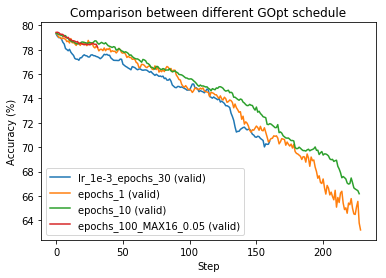

In [73]:
labels = list(out_dirs.keys())
for i, df in enumerate(dfs):
    plt.plot(np.arange(len(df)), df['Valid Acc.'], label='{} (valid)'.format(labels[i]))
    
plt.title('Comparison between different GOpt schedule')
plt.ylabel('Accuracy (%)')
plt.xlabel('Step')
plt.legend()

Let's look at the validation accuracy mainly.

Before the 10-th step, the validation accuracy goes down constantly, and it keeps for a while (~20 steps), and then goes down significantly again until the end.

In [74]:
[df.head(10)['Valid Acc.'].values for df in dfs]

[array([ 79.279999,  79.089996,  78.989998,  78.989998,  78.869995,
         78.610001,  78.470001,  78.089996,  78.009995,  77.909996]),
 array([ 79.369995,  79.209999,  79.      ,  79.019997,  78.889999,
         78.970001,  78.900002,  78.860001,  78.659996,  78.720001]),
 array([ 79.349998,  79.309998,  79.25    ,  79.199997,  79.18    ,
         79.099998,  79.159996,  79.150002,  78.970001,  78.919998]),
 array([ 79.419998,  79.43    ,  79.389999,  79.279999,  79.259995,
         79.25    ,  79.079994,  79.029999,  78.979996,  79.009995])]

One question that might be interesting to look at: _can we compare the validation accuracy from pruning different layers and the estimated cost?_

## Analysis: Step 1

Here we run pruning for one step on every module. The pruned module is fine-tuned for one epoch only. We also record the cost value that we extract from running the pruning algorithm.

In [91]:
dbg_dir = '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/final/condensenet86/cifar100/prune/gopt_v2/debug_first_step/'
n_mods = len(os.listdir(dbg_dir)) - 1
data = []

for i in range(n_mods):
    mod_dir = os.path.join(dbg_dir, 'mod_{}'.format(i))
    meta_file = os.path.join(mod_dir, 'meta_data.json')
    with open(meta_file, 'r') as f:
        meta_data = json.load(f)
    
    data.append([meta_data['mod_name'], meta_data['cost'], meta_data['val_acc'], meta_data['init_acc']])

df = pd.DataFrame(data, columns=['mod_name', 'cost', 'val_acc', 'init_acc'])

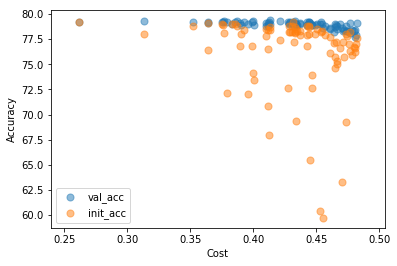

In [117]:
plt.scatter(df['cost'], df['val_acc'], s=50, alpha=.5, label='val_acc')
plt.scatter(df['cost'], df['init_acc'], s=50, alpha=.5, label='init_acc')

plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.legend()

The figure above shows that cost is not a very good indicator of the importance of weights. Basically, even a module that has high cost, they can still be recovered to an accuracy that is similar to the smallest cost.

However, we should notice that, only the sample with the smallest cost can have the same validation accuracy before and after fine-tuning, which implies that the value of cost is somehow important still (WTF?)

Also, **smaller cost means less likely to loss much accuracy**.

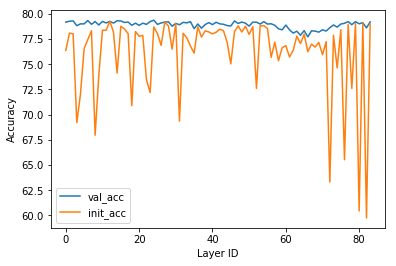

In [121]:
plt.plot(df['val_acc'])
plt.plot(df['init_acc'])

plt.xlabel('Layer ID')
plt.ylabel('Accuracy')
plt.legend()

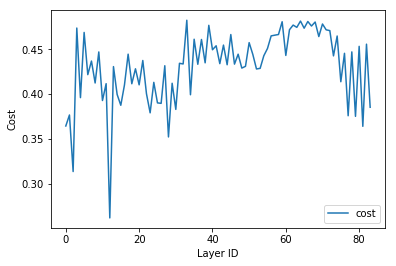

In [122]:
plt.plot(df['cost'])
plt.xlabel('Layer ID')
plt.ylabel('Cost')
plt.legend()

Is there any correlation between metrics and kernel size of convolution?

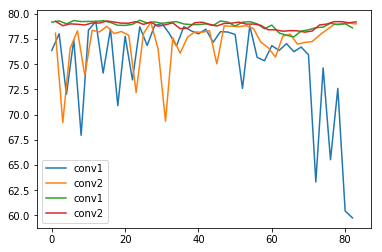

In [118]:
plt.plot(df.loc[df['mod_name'].str.contains('conv1')]['init_acc'], label='conv1')
plt.plot(df.loc[df['mod_name'].str.contains('conv2')]['init_acc'], label='conv2')
plt.plot(df.loc[df['mod_name'].str.contains('conv1')]['val_acc'], label='conv1')
plt.plot(df.loc[df['mod_name'].str.contains('conv2')]['val_acc'], label='conv2')
plt.legend()

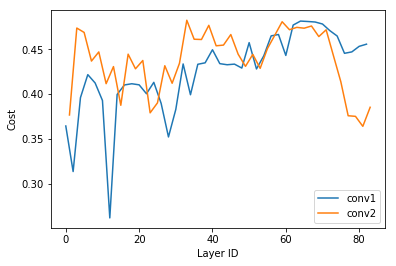

In [120]:
plt.plot(df.loc[df['mod_name'].str.contains('conv1')]['cost'], label='conv1')
plt.plot(df.loc[df['mod_name'].str.contains('conv2')]['cost'], label='conv2')
plt.xlabel('Layer ID')
plt.ylabel('Cost')
plt.legend()

Now let's see how will this effect be the same on other models, or will changing a cost make an improvement?

In [124]:
dbg_dir = '/mnt/ccnas2/bdp/rz3515/train/gumi/evaluation/iccv19/final/condensenet86/cifar100/prune/gopt_v2/debug_first_step_taylor/'
n_mods = len(os.listdir(dbg_dir)) - 2
data = []

for i in range(n_mods):
    mod_dir = os.path.join(dbg_dir, 'mod_{}'.format(i))
    meta_file = os.path.join(mod_dir, 'meta_data.json')
    with open(meta_file, 'r') as f:
        meta_data = json.load(f)
    
    data.append([meta_data['mod_name'], meta_data['cost'], meta_data['val_acc'], meta_data['init_acc']])

df = pd.DataFrame(data, columns=['mod_name', 'cost', 'val_acc', 'init_acc'])

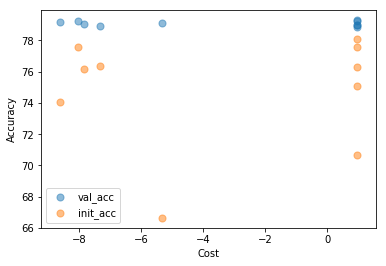

In [125]:
plt.scatter(df['cost'], df['val_acc'], s=50, alpha=.5, label='val_acc')
plt.scatter(df['cost'], df['init_acc'], s=50, alpha=.5, label='init_acc')

plt.xlabel('Cost')
plt.ylabel('Accuracy')
plt.legend()